# Error mitigation with the Qiskit Runtime Estimator primitive

In this tutorial, we'll explore the error suppression and error mitigation options available with the Estimator primitive from Qiskit Runtime. We'll construct a circuit and observable and submit jobs using the Estimator primitive using different error mitigation settings. Then, we'll plot the results to observe the effects of the various settings.

## Generate quantum circuit and observable

First, let's construct a circuit and an observable to measure.

For our circuit, let's use the [`EfficientSU2`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.EfficientSU2#efficientsu2) circuit from the Qiskit circuit library. `EfficientSU2` is a parameterized quantum circuit designed to be efficiently executable on quantum hardware with limited qubit connectivity, while still being expressive enough to solve problems in application domains like optimization and chemistry. It's built by alternating layers of parameterized single-qubit gates with a layer containing a fixed pattern of two-qubit gates, for a chosen number of repetitions. The pattern of two-qubit gates can be specified by the user. We'll use the built-in `pairwise` pattern because it minimizes the circuit depth by packing the two qubit gates as densely as possible. This pattern can be executed using only linear qubit connectivity.

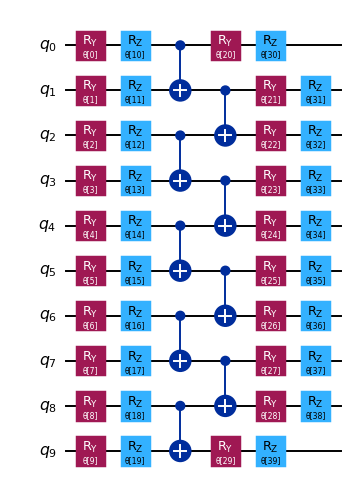

In [1]:
from qiskit.circuit.library import EfficientSU2

n_qubits = 10
reps = 1

circuit = EfficientSU2(n_qubits, entanglement="pairwise", reps=reps)

circuit.decompose().draw("mpl", scale=0.7)

For our observable, let's take the Pauli $Z$ operator acting on the last qubit, $Z I \cdots I$.

In [2]:
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp("Z" + "I" * (n_qubits - 1))

At this point, we could proceed to run our circuit and measure the observable. However, we'd like to compare the output of the quantum device with the correct answer, i.e., the theoretical value of the observable if the circuit were executed without error. For small quantum circuits we can calculate this value by simulating the circuit on a classical computer, but we can't do this for larger, utility-scale circuits. Here, we'll work around this issue with the "mirror circuit" technique, which is useful for benchmarking the performance of quantum devices.

### Mirror circuit

In the mirror circuit technique, we concatenate the circuit with its inverse circuit, which is formed by inverting each gate of the circuit in reverse order. The resulting circuit implements the identity operator, which can trivially be simulated. Because the structure of the original circuit is preserved in the mirror circuit, executing the mirror circuit still gives us an idea of how the quantum device would perform on the original circuit.

In the following code cell, we assign random parameters to our circuit, and then construct the mirror circuit using the [`UnitaryOverlap`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.UnitaryOverlap#unitaryoverlap) class. Before mirroring the circuit, we append a [barrier](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.Barrier#barrier) instruction to it to prevent the transpiler from merging the two parts of the circuit on either side of the barrier. Without the barrier, the transpiler would merge the original circuit with its inverse, resulting in a transpiled circuit without any gates. 

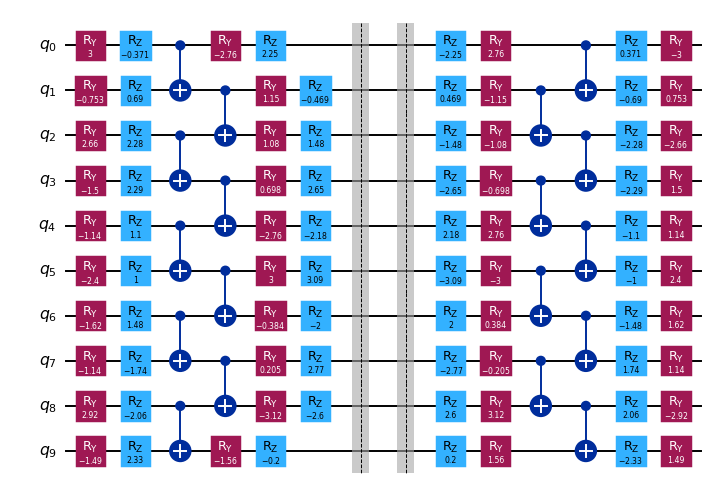

In [3]:
import numpy as np
from qiskit.circuit.library import UnitaryOverlap

# Generate random parameters
rng = np.random.default_rng(1234)
params = rng.uniform(-np.pi, np.pi, size=circuit.num_parameters)

# Assign the parameters to the circuit
assigned_circuit = circuit.assign_parameters(params)

# Add a barrier to prevent circuit optimization of mirrored operators
assigned_circuit.barrier()

# Construct mirror circuit
mirror_circuit = UnitaryOverlap(assigned_circuit, assigned_circuit)

mirror_circuit.decompose().draw("mpl", scale=0.7)

## Optimize circuits for quantum hardware execution

Before we can run our circuit on the hardware, we need to optimize it for hardware execution. This process involves a few steps:

- Pick a qubit layout that maps the virtual qubits of our circuit to physical qubits on the hardware.
- Insert swap gates as needed to route interactions between qubits that are not connected.
- Translate the gates in our circuit to [Instruction Set Architecture (ISA)](https://docs.quantum.ibm.com/transpile#instruction-set-architecture) instructions that can directly be executed on the hardware.
- Perform circuit optimizations to minimize the circuit depth and gate count.

The transpiler built into Qiskit can perform all of these steps for us. Because we've chosen a hardware-efficient circuit, the transpiler should be able to pick a qubit layout that does not require any swap gates to be inserted for routing interactions.

Before we can optimize our circuit for hardware, we need to choose the hardware backend we want to use. Let's use the IBM Osaka backend.

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

backend = service.get_backend("ibm_osaka")

We can transpile our circuit for our chosen backend by creating a pass manager and then running the pass manager on the circuit. An easy way to create a pass manager is to use the [`generate_preset_pass_manager`](https://docs.quantum.ibm.com/api/qiskit/transpiler_preset#qiskit.transpiler.preset_passmanagers.generate_preset_pass_manager) function. See [Transpile with pass managers](https://docs.quantum.ibm.com/transpile/transpile-with-pass-managers) for a more detailed explanation of transpiling with pass managers.

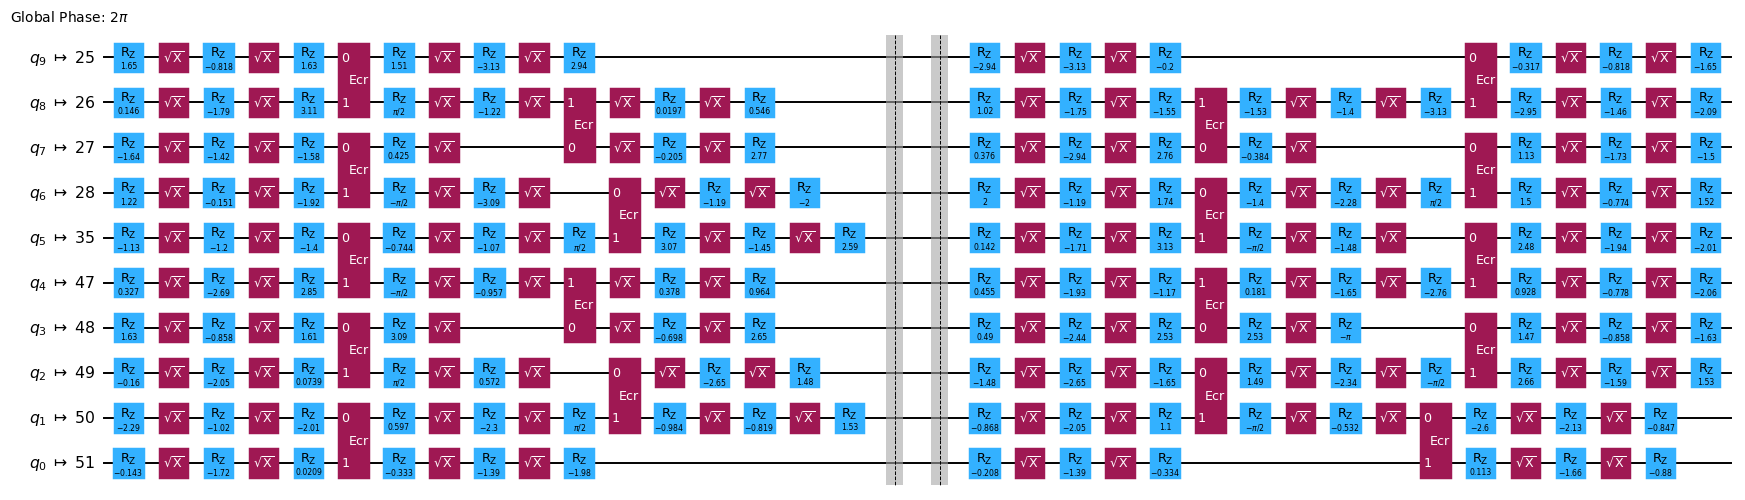

In [5]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=1234
)
isa_circuit = pass_manager.run(mirror_circuit)

isa_circuit.draw("mpl", idle_wires=False, scale=0.7, fold=-1)

Now, our transpiled circuit contains only ISA instructions. The single-qubit gates have been decomposed in terms of $\sqrt{X}$ gates and $R_z$ rotations, and the CX gates have been decomposed into [ECR gates](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ECRGate#ecrgate) and single-qubit rotations.

The transpilation process has mapped the virtual qubits of our circuit to physical qubits on the hardware. The information about the qubit layout is stored in the `layout` attribute of the transpiled circuit. Our observable was also defined in terms of the virtual qubits, so we need to apply this layout to the observable. This is done using the [`apply_layout`](https://docs.quantum.ibm.com/api/qiskit/qiskit.quantum_info.SparsePauliOp#apply_layout) method of `SparsePauliOp`.

In [6]:
isa_observable = observable.apply_layout(isa_circuit.layout)

print("Original observable:")
print(observable)
print()
print("Observable with layout applied:")
print(isa_observable)

Original observable:
SparsePauliOp(['ZIIIIIIIII'],
              coeffs=[1.+0.j])

Observable with layout applied:
SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])


## Run circuits using the Estimator primitive

Now, we're ready to run our circuit using the Estimator primitive.

We'll submit 5 separate jobs, starting with no error suppression or mitigation, and successively enabling various error suppression and mitigation options available in Qiskit Runtime. For information about the options, you can refer to the following pages:

- [Overview of all options](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/options)
- [Dynamical decoupling](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.DynamicalDecouplingOptions)
- [Resilience, including measurement error mitigation and zero-noise extrapolation (ZNE)](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.ResilienceOptionsV2)
- [Twirling](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.TwirlingOptions)

Because our jobs can run independently of each other, we'll use [batch mode](https://docs.quantum.ibm.com/run/run-jobs-batch) to allow Qiskit Runtime to optimize the timing of their execution.

In [7]:
from qiskit_ibm_runtime import Batch, EstimatorV2 as Estimator

pub = (isa_circuit, isa_observable)

jobs = []

with Batch(backend=backend) as batch:
    estimator = Estimator(session=batch)
    # Set number of shots
    estimator.options.default_shots = 100_000
    # Disable runtime compilation and error mitigation
    estimator.options.optimization_level = 0
    estimator.options.resilience_level = 0

    # Run job with no error mitigation
    job0 = estimator.run([pub])
    jobs.append(job0)

    # Add dynamical decoupling (DD)
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XpXm"
    job1 = estimator.run([pub])
    jobs.append(job1)

    # Add readout error mitigation (DD + TREX)
    estimator.options.resilience.measure_mitigation = True
    job2 = estimator.run([pub])
    jobs.append(job2)

    # Add gate twirling (DD + TREX + Gate Twirling)
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = 32
    job3 = estimator.run([pub])
    jobs.append(job3)

    # Add zero-noise extrapolation (DD + TREX + Gate Twirling + ZNE)
    estimator.options.resilience.zne_mitigation = True
    estimator.options.resilience.zne.noise_factors = (1, 3, 5)
    estimator.options.resilience.zne.extrapolator = ("exponential", "linear")
    job4 = estimator.run([pub])
    jobs.append(job4)

## Analyze data

Finally, let's analyze the data. We'll retrieve the job results, extract the measured expectation values from them, and plot the values.

In [ ]:
import matplotlib.pyplot as plt

# Retrieve the job results
results = [job.result() for job in jobs]

# Unpack the PUB results (there's only one PUB result in each job result)
pub_results = [result[0] for result in results]

# Unpack the expectation values
expectation_vals = np.array([float(pub_result.data.evs) for pub_result in pub_results])

# Plot the expectation values
fig, ax = plt.subplots()
labels = ["No mitigation", "+ DD", "+ TREX", "+ Twirling", "+ ZNE"]
ax.bar(range(len(labels)), expectation_vals, label="experiment")
ax.axhline(y=1.0, color="gray", linestyle="--", label="ideal")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel("Expectation value")
ax.legend(loc="upper left")

plt.show()

The addition of dynamical decoupling seems to have worsened performance. This is not surprising, because our circuit is very dense. Dynamical decoupling is primarily useful when there are large gaps in the circuit during which qubits sit idle without gates being applied to them. When these gaps are not present, dynamical decoupling is not effective, and can actually worsen performance due to errors in the dynamical decoupling pulses themselves.

Let's try the experiment again without dynamical decoupling.

In [ ]:
jobs = []

with Batch(backend=backend) as batch:
    estimator = Estimator(session=batch)
    # Set number of shots
    estimator.options.default_shots = 100_000
    # Disable runtime compilation and error mitigation
    estimator.options.optimization_level = 0
    estimator.options.resilience_level = 0

    # Run job with no error mitigation
    job0 = estimator.run([pub])
    jobs.append(job0)

    # Add readout error mitigation TREX
    estimator.options.resilience.measure_mitigation = True
    job1 = estimator.run([pub])
    jobs.append(job1)

    # Add gate twirling (TREX + Gate Twirling)
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = 32
    job2 = estimator.run([pub])
    jobs.append(job2)

    # Add zero-noise extrapolation (TREX + Gate Twirling + ZNE)
    estimator.options.resilience.zne_mitigation = True
    estimator.options.resilience.zne.noise_factors = (1, 3, 5)
    estimator.options.resilience.zne.extrapolator = ("exponential", "linear")
    job3 = estimator.run([pub])
    jobs.append(job3)

# Retrieve the job results
results = [job.result() for job in jobs]

# Unpack the PUB results (there's only one PUB result in each job result)
pub_results = [result[0] for result in results]

# Unpack the expectation values
expectation_vals = np.array([float(pub_result.data.evs) for pub_result in pub_results])

# Plot the expectation values
fig, ax = plt.subplots()
labels = ["No mitigation", "+ TREX", "+ Twirling", "+ ZNE"]
ax.bar(range(len(labels)), expectation_vals, label="experiment")
ax.axhline(y=1.0, color="gray", linestyle="--", label="ideal")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel("Expectation value")
ax.legend(loc="upper left")

plt.show()

The results look better now.

## Scale the experiment up

Now that we've tested a small 10-qubit circuit, let's try running a larger circuit.

In [ ]:
n_qubits = 50
reps = 1

# Construct circuit and observable
circuit = EfficientSU2(n_qubits, entanglement="pairwise", reps=reps)
observable = SparsePauliOp("Z" + "I" * (n_qubits - 1))

# Assign parameters to circuit
params = rng.uniform(-np.pi, np.pi, size=circuit.num_parameters)
assigned_circuit = circuit.assign_parameters(params)
assigned_circuit.barrier()

# Construct mirror circuit
mirror_circuit = UnitaryOverlap(assigned_circuit, assigned_circuit)

# Transpile circuit and observable
isa_circuit = pass_manager.run(mirror_circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)

# Run jobs
pub = (isa_circuit, isa_observable)

jobs = []

with Batch(backend=backend) as batch:
    estimator = Estimator(session=batch)
    # Set number of shots
    estimator.options.default_shots = 100_000
    # Disable runtime compilation and error mitigation
    estimator.options.optimization_level = 0
    estimator.options.resilience_level = 0

    # Run job with no error mitigation
    job0 = estimator.run([pub])
    jobs.append(job0)

    # Add readout error mitigation TREX
    estimator.options.resilience.measure_mitigation = True
    job1 = estimator.run([pub])
    jobs.append(job1)

    # Add gate twirling (TREX + Gate Twirling)
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = 32
    job2 = estimator.run([pub])
    jobs.append(job2)

    # Add zero-noise extrapolation (TREX + Gate Twirling + ZNE)
    estimator.options.resilience.zne_mitigation = True
    estimator.options.resilience.zne.noise_factors = (1, 3, 5)
    estimator.options.resilience.zne.extrapolator = ("exponential", "linear")
    job3 = estimator.run([pub])
    jobs.append(job3)

# Retrieve the job results
results = [job.result() for job in jobs]

# Unpack the PUB results (there's only one PUB result in each job result)
pub_results = [result[0] for result in results]

# Unpack the expectation values
expectation_vals = np.array([float(pub_result.data.evs) for pub_result in pub_results])

# Plot the expectation values
fig, ax = plt.subplots()
labels = ["No mitigation", "+ TREX", "+ Twirling", "+ ZNE"]
ax.bar(range(len(labels)), expectation_vals, label="experiment")
ax.axhline(y=1.0, color="gray", linestyle="--", label="ideal")
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels)
ax.set_ylabel("Expectation value")
ax.legend(loc="upper left")

plt.show()